In [1]:
import notebook_functions
reload(notebook_functions)
from notebook_functions import *
import os, pandas as pd, cPickle as pickle
from nolearn.lasagne.visualize import plot_conv_activity, plot_conv_weights, plot_occlusion
from lasagne.layers import get_output, get_output_shape
import theano.tensor as T
import theano
%pylab inline

Couldn't import dot_parser, loading of dot files will not be possible.
Populating the interactive namespace from numpy and matplotlib

Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, CuDNN 4004)

pylab import has clobbered these variables: ['ceil', 'floor']
`%matplotlib` prevents importing * from pylab and numpy


In [2]:
val_dir =  "/media/dylan/Science/Kaggle-Data/distracted_drivers/test/"

In [3]:
def image_gen_from_dir_with_filenames(data_dir, batches, size):
    result = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir) 
                  for f in filenames if os.path.splitext(f)[1] == '.jpg']
    image_files = []
    filenames = []
    for file_path in result:
        image_files.append(read_img_file_PIL(file_path, size=input_volume_shape))
        filenames.append(os.path.basename(file_path))
        if len(image_files) == batches:
            X = np.asarray(image_files, dtype=np.float32)
            X = exposure.rescale_intensity(X, out_range=(-1,1))
            yield X, filenames
            image_files = []
            filenames = []
            
    # end result loop, yield any leftover image files
    X = np.asarray(image_files, dtype=np.float32)
    X = exposure.rescale_intensity(X, out_range=(-1,1))
    yield X, filenames

In [4]:
X, filenames = image_gen_from_dir_with_filenames(val_dir, 20, input_volume_shape).next()

In [5]:
dir_name = 'net.vgg.large.l2.5e4'
validation_file_name = "{}/vloss-{}.txt".format(dir_name, dir_name)
model_file_name = "{}/{}.pickle".format(dir_name, dir_name)
best_weights_file_name = "{}/bw-{}.weights".format(dir_name, dir_name)

In [6]:
with open(model_file_name, 'rb') as reader:
    net = pickle.load(reader)

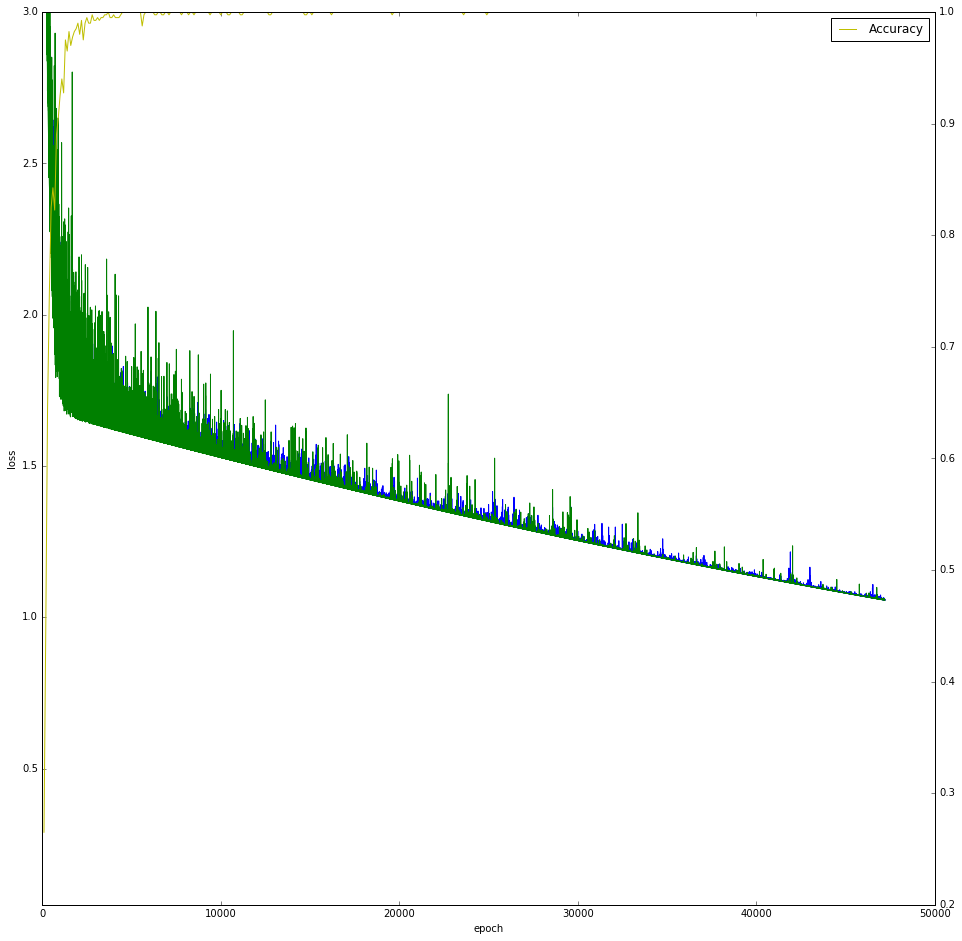

In [7]:
plot_validation_loss(net, validation_file_name,ylim=[0.05,3])

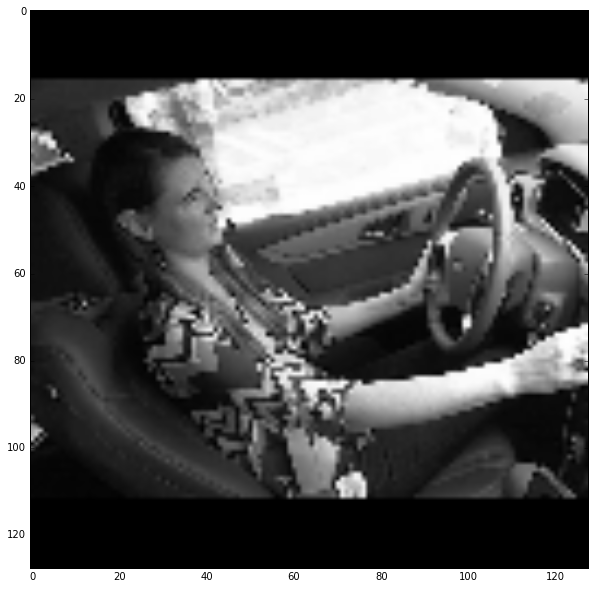

In [8]:
sample = X[0].reshape(1, 1, X[0].shape[0], X[0].shape[1])
plt.figure(figsize=(10,10))
plt.imshow(X[0], cmap='gray')
plt.show()

Original layer shape: (32, 128, 128)
Last shape: (6, 129, 6, 129)
Visualization shape (774, 774):
Prediction 5. [[  6.49250376e-10   7.48784932e-13   2.28270576e-08   3.51650176e-09
    2.22998330e-14   1.00000000e+00   1.73200281e-13   1.32145284e-09
    2.63800475e-11   8.53693505e-10]].


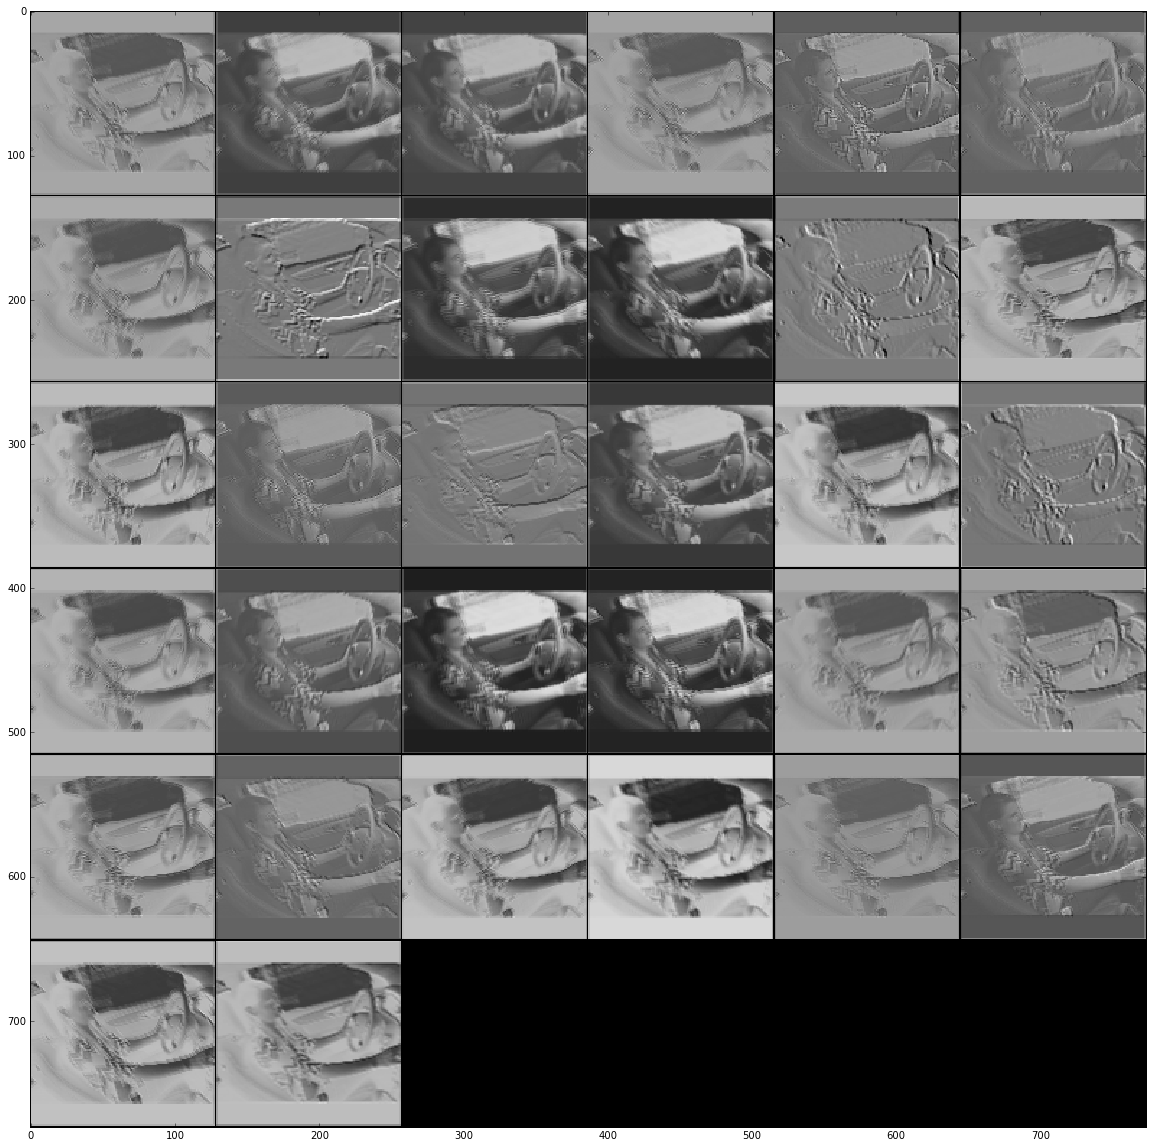

In [9]:
xs = T.tensor4('xs').astype(theano.config.floatX)
get_activity = theano.function([xs], get_output(net.layers_[1], xs))
sample = np.float32(X[0].reshape((1,1,128,128)))
activity = get_activity(sample)
activityS = activity.shape
vis_square(activity.reshape((activityS[1], activityS[2], activityS[3])))
probs = net.predict_proba(sample)
pred = np.argmax(probs)
print("Prediction {}. {}.".format(pred, probs))
plt.show()

# Evaluation Proper

In [10]:
image_gen = image_gen_from_dir_with_filenames(val_dir, 40, input_volume_shape)
threaded_gen = threaded_generator(image_gen, num_cached=40)

all_probs = []
all_file_names = []
for X, file_names in threaded_gen:
    all_probs.extend(net.predict_proba(X.reshape(-1, 1, input_volume_shape[0], input_volume_shape[1])))
    all_file_names.extend(file_names)

In [11]:
df = pd.DataFrame(np.asarray(all_probs), 
                  index = all_file_names, columns=["c0","c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9"])
df.index.name = 'img'
df.shape

(79726, 10)

In [15]:
df.to_csv("preds.l25e4.csv")

In [16]:
!head preds.l25e4.csv

img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img_73540.jpg,6.49250375684e-10,7.48786883192e-13,2.28270877756e-08,3.51649709351e-09,2.22999499048e-14,1.0,1.73201202187e-13,1.32145105969e-09,2.63799086742e-11,8.53695725223e-10
img_9672.jpg,1.26471319528e-10,3.30446994212e-08,0.999999761581,1.06483499795e-09,7.88587858208e-12,1.04111016697e-07,6.734664737e-08,8.95548435409e-09,6.59207133324e-09,7.00661750841e-11
img_49295.jpg,4.79334261172e-09,3.5095846368e-11,1.30180394242e-10,5.74514160689e-06,0.999994277954,4.42241521181e-10,7.86840015365e-09,1.46674512813e-11,1.54383439366e-08,1.14781539828e-09
img_91517.jpg,0.643362343311,5.50125832888e-07,7.59603381084e-07,0.00100258784369,1.45620218106e-08,0.355632692575,3.16931814126e-09,7.22964674238e-11,5.76816177045e-08,9.72940483734e-07
img_51925.jpg,0.71319681406,4.15574913859e-06,1.03383881651e-05,6.80526572978e-05,0.000646520871669,0.117459341884,1.87978384929e-05,5.40435223684e-07,0.000777049397584,0.167818382382
img_87962.jpg,2.10766318881e-15,1.429